In [1]:
import kagglehub
import os
import shutil

# 1. Download the dataset
path = kagglehub.dataset_download("marquis03/flower-classification")

# 2. Define your target destination
destination = "data/Flowers"

# 3. Create the directory (and any parent folders)
os.makedirs(destination, exist_ok=True)

# 4. Move the contents from the cache to your folder
# We use copytree if the destination doesn't exist,
# or a simple loop if you want to move files into an existing folder.
for item in os.listdir(path):
    s = os.path.join(path, item)
    d = os.path.join(destination, item)
    if os.path.isdir(s):
        shutil.copytree(s, d, dirs_exist_ok=True)
    else:
        shutil.copy2(s, d)

print(f"Dataset successfully moved to: {destination}")

100%|██████████| 205M/205M [00:05<00:00, 39.2MB/s]

Extracting files...


Dataset successfully moved to: data/Flowers


Trainable: layer4.0.conv1.weight
Trainable: layer4.0.bn1.weight
Trainable: layer4.0.bn1.bias
Trainable: layer4.0.conv2.weight
Trainable: layer4.0.bn2.weight
Trainable: layer4.0.bn2.bias
Trainable: layer4.0.downsample.0.weight
Trainable: layer4.0.downsample.1.weight
Trainable: layer4.0.downsample.1.bias
Trainable: layer4.1.conv1.weight
Trainable: layer4.1.bn1.weight
Trainable: layer4.1.bn1.bias
Trainable: layer4.1.conv2.weight
Trainable: layer4.1.bn2.weight
Trainable: layer4.1.bn2.bias
Trainable: fc.weight
Trainable: fc.bias
Total parameters:: 11183694
Trainable parameters:: 8400910
---------------------
Epoch: 1/10:-
Traning loss: 0.9549157462108915 
Traning Accuracy: 76.30112886673508 
Val loss: 0.29851317405700684 
Val Accuracy: 89.79591836734694 
---------------------
Epoch: 2/10:-
Traning loss: 0.31808082592264514 
Traning Accuracy: 91.25494795484533 
Val loss: 0.18577081710100174 
Val Accuracy: 93.87755102040816 
---------------------
Epoch: 3/10:-
Traning loss: 0.2125476161105053

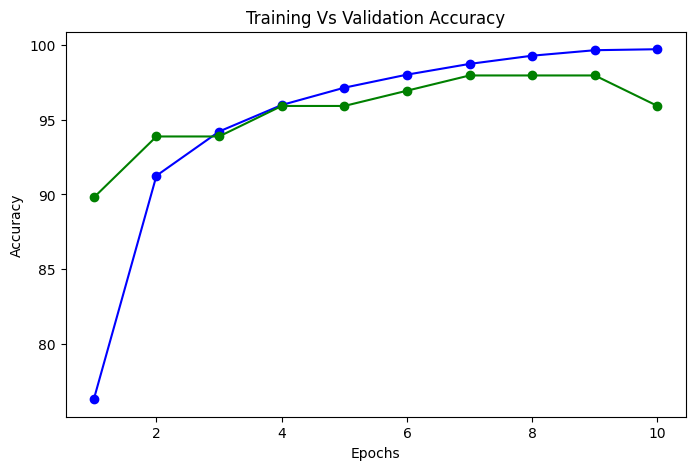

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models,transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.486,0.455,0.439],
        std=[0.255,0.299,0.225]
    )
])

train_dataset = ImageFolder(
    root="data/Flowers/train",
    transform=transform
)
test_dataset = ImageFolder(
    root="data/Flowers/val",
    transform = transform
)
train_loader = DataLoader(dataset = train_dataset,shuffle=True,batch_size=64,pin_memory=True,num_workers=2)
test_loader = DataLoader(dataset = test_dataset,shuffle=False,batch_size=64,pin_memory=True,num_workers=2)

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features,num_classes)
model.to(device)

total_param,train_param = 0,0

for name,param in model.named_parameters():
    total_param+=param.numel()
    if param.requires_grad:
        train_param+=param.numel()
        print(f"Trainable: {name}")

print(f"Total parameters:: {total_param}")
print(f"Trainable parameters:: {train_param}")


TARGET_ACC = 99.9
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params':model.layer4.parameters(),'lr':1e-5},
    {'params':model.fc.parameters(),'lr':5e-4},
])
train_acc_list,val_acc_list = [],[]

for epoch in range(epochs):

    training_total = 0
    training_loss = 0
    training_correct = 0

    model.train()
    for images,labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_total+=labels.size(0)
        training_loss+=loss.item()
        _,prediction = torch.max(logits,1)
        training_correct+= (prediction==labels).sum().item()

    training_accuracy = 100* training_correct / training_total
    training_loss /= len(train_loader)

    model.eval()
    val_total,val_correct,val_loss =0,0,0

    with torch.no_grad():
        for images,labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = criterion(logits,labels)

            val_total+=labels.size(0)
            val_loss+=loss.item()
            _,prediction = torch.max(logits,1)
            val_correct+= (prediction==labels).sum().item()


        val_accuracy = 100*val_correct / val_total
        val_loss /= len(test_loader)


        train_acc_list.append(training_accuracy)
        val_acc_list.append(val_accuracy)

    if(epoch%1==0):
        print("---------------------")
        print(f"Epoch: {epoch+1}/{epochs}:-")
        print(f"Traning loss: {training_loss:,} ")
        print(f"Traning Accuracy: {training_accuracy:,} ")
        print(f"Val loss: {val_loss:,} ")
        print(f"Val Accuracy: {val_accuracy:,} ")

    if(val_accuracy>=TARGET_ACC):
        print(f"Val accuracy reached target!.")
        break



epochs_range = range(1,len(train_acc_list)+1)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(epochs_range,train_acc_list,label=["Training Accuracy"],color="Blue",marker="o")
plt.plot(epochs_range,val_acc_list,label=["Validation Accuracy"],color="Green",marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Vs Validation Accuracy")
plt.show()